# "Predict the Crude Oil production trend" Data Challenge by Société Générale

The dataset was provided by the french bank "Société Générale". You can find the link of the challenge <a href="https://challengedata.ens.fr/en/challenge/25/predict_the_crude_oil_production_trend.html">here</a>.

The objective of this challenge is to predict the probability of <strong>increase of Crude Oil production <em>per quarter per country</em></strong> based on several indicators collected during the previous year.

Current score: 0.824 (ranked 12th out of 70)

---
# Introduction

In this presentation, we will be going through the main steps of a classic data prediction project.
Please note that, for the sake of clarity, this is a summary of the initiatives I took when looking for a solution. 

<strong>Agenda: <br/>
1) Exploring the data... <br/>
2) Data cleaning and preprocessing <br/>
3) Feature selection <br/>
4) Models <br/>
5) Next steps and conclusion</strong>


In [6]:
##### Importing main packages and loading data

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

data_train = pd.read_csv('training_set.csv', delimiter = ";")
data_test = pd.read_csv('test_set.csv', delimiter = ";")
target = pd.read_csv('training_output.csv', delimiter = ";")

---
# 1) Exploring data...

In this part, we are going to explore the dataset in order to have a better understanding of where, when and in which conditions an increase in Crude Oil production happens.

/Users/user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


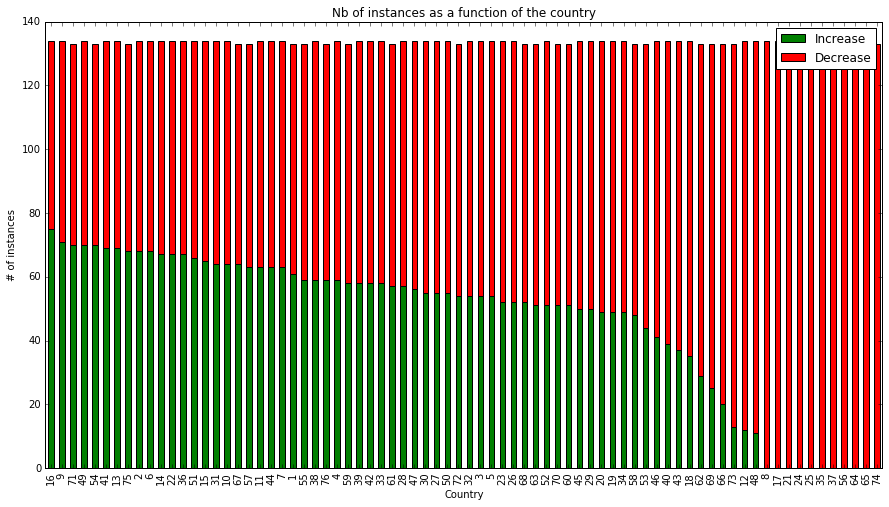

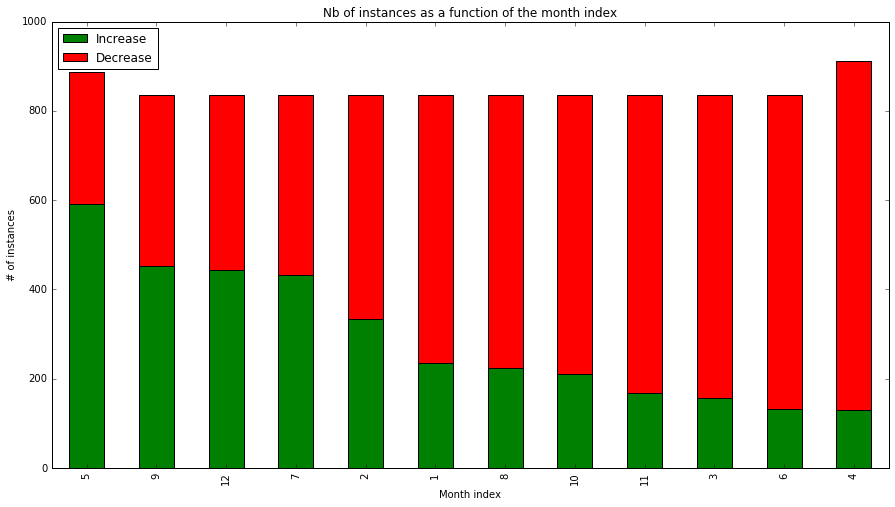

In [7]:
data_joined = data_train.join(target.set_index("ID"), on = "ID")

##Checking if the increases are mostly happening in some countries
##See graph 1
nb_inc_per_country = data_joined[data_joined.Target == 1]["country"].value_counts()
nb_dec_per_country = data_joined[data_joined.Target == 0]["country"].value_counts()
stacked_country = pd.concat([nb_inc_per_country, nb_dec_per_country], axis = 1)
stacked_country.columns = ["Increase", "Decrease"]

plt.figure()
stacked_country_plot = stacked_country.sort(columns = "Increase", ascending = False).plot(kind = "bar", stacked = True, figsize = (15,8), color = ['g', 'r'])
stacked_country_plot.set_ylabel('# of instances')
stacked_country_plot.set_xlabel('Country')
stacked_country_plot.set_title('Nb of instances as a function of the country')

##Checking if there is a seasonal behavior
##See graph 2
nb_inc_per_month = data_joined[data_joined.Target == 1]["month"].value_counts()
nb_dec_per_month = data_joined[data_joined.Target == 0]["month"].value_counts()
stacked_month = pd.concat([nb_inc_per_month, nb_dec_per_month], axis = 1)
stacked_month.columns = ["Increase", "Decrease"]

plt.figure()
stacked_month_plot = stacked_month.sort(columns = "Increase", ascending = False).plot(kind = "bar", stacked = True, figsize = (15,8), color = ['g', 'r'])
stacked_month_plot.set_ylabel('# of instances')
stacked_month_plot.set_xlabel('Month index')
stacked_month_plot.set_title('Nb of instances as a function of the month index')

- From the first bar chart, we can conclude that there are huge differences between some countries: if a majority of them have experienced an increase approx. 60/80 times out of 130, there are some for which crude oil production have always decreased since 2002. This fact and the explanatory variables being very different from a country to another made me think that creating <strong>a model per country</strong> could be a good idea.


- From the second bar chart, we can conclude that there seems to be some specific months where the production is more likely to increase. Moreover, there is a problem raised here. The production is most likely to go up when month = 5, and most likely to decrease when month = 4. But the algorithm will interpret 4 as close to 5. To solve this problem, we will create dummy variables for each month (see Data Cleaning and Preprocessing)

In [8]:
from scipy import stats

## Here, we test if the means of a given variable for the groups "Increase" and "Decrease" are
## significantly different. To do so, we perform t-tests.
## H0: the means are equal.
## The variable for which the means are significantly different (i.e. p-value < 0.05) can be
## considered more "useful" to detect whether or not there will be an increase

dict_variables = {}
for column in list(data_joined.columns)[3:-1]:
    positive_ex = data_joined[data_joined.Target == 1][column].fillna(data_joined[data_joined.Target == 1][column].median())
    negative_ex = data_joined[data_joined.Target == 0][column].fillna(data_joined[data_joined.Target == 1][column].median())
    if stats.ttest_ind(positive_ex, negative_ex, axis=0, equal_var=False)[1] < 0.05:
        month_index = column.split("_")[0]
        variable = column.split("_")[1]
        if variable in dict_variables.keys():
            dict_variables[variable].append(month_index)
        else:
            dict_variables[variable] = [month_index]

print('"Useful" variables:\n')
for keys,values in dict_variables.items():
    print(keys)
    print("Relative month index: " + str(values) + "\n")

"Useful" variables:

diffSumProduction(kmt)
Relative month index: ['1', '2', '3', '5', '6', '7', '8', '10', '11', '12']

diffSumClosing stocks(kmt)
Relative month index: ['1', '3', '4', '10', '11']

diffImports(kmt)
Relative month index: ['1', '2', '5', '6', '7', '11', '12']

diffSumExports(kmt)
Relative month index: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '11', '12']

diffSumRefinery intake(kmt)
Relative month index: ['1', '2', '3', '4', '5', '6', '7', '8', '11', '12']

diffExports(kmt)
Relative month index: ['1', '2', '3', '5', '6', '7', '8', '11', '12']

diffWTI
Relative month index: ['3', '6', '7', '9', '10', '12']

diffRefinery intake(kmt)
Relative month index: ['1', '2', '6', '12']

diffSumImports(kmt)
Relative month index: ['1', '2', '5', '6', '7', '8', '9', '10', '11', '12']



You can see above the variables for which the means are significantly different when Target = 1 and when Target = 0. The list then gives the index of the variable. The idea behind is to detect whether the time window of 12 months explanatory variable is optimal. We note that: 
- There is a predominance of the "Sum" variables, which shows the importance of what is happening worldwide
- Imports and Exports are capital for the prediction purpose
- Closing Stocks never appears
- For a majority of the useful variables, the values of the year before (variables with index "1") still can influence. It may be worth trying to use even "older" variables.

---
# 2) Data cleaning and preprocessing

In [9]:
#Combine both training and test datasets to perform the same transformations
combined = data_train.append(data_test).reset_index().drop('index', axis=1).set_index("ID")

#This function will fill NaN values based on the median (more robust to outliers) 
#per country and month
#Indeed, we have seen in "1) Exploratoring the data..." that there was huge differences
#of the values according to these two variables

def fill_nan():
    global combined
    features_to_fill = list((combined.describe().loc["count"].index[((combined.describe().loc["count"] != 12159.0) == True)]))
    
    medians = combined.groupby(["country", "month"]).median()
    medians["country, month"] = np.array(medians.index)
    
    def lookfor_median_groups(row, column):
        return float(medians[medians["country, month"] == (row.country, row.month)][column])
    
    combined_and_filled = pd.DataFrame()
    for column in features_to_fill:
        filled_column = pd.DataFrame(combined.apply(lambda row: lookfor_median_groups(row, column) if np.isnan(row[column]) else row[column], axis = 1), columns = [column])  
        combined_and_filled = pd.concat([combined_and_filled, filled_column], axis = 1)
    
    combined[features_to_fill] = combined_and_filled
    print("Missing values filled: ok.")

#This function will scale the values of some variables
def scale():
    global combined
    features_to_scale = list(combined.columns)
    features_to_scale.remove("country")
    features_to_scale.remove("month")
    combined[features_to_scale] = combined[features_to_scale].apply(lambda x: (x-x.mean())/x.std(), axis=0)
    print("Scaling features: ok.")

#This function will transform the categorical variable month into dummy variables
def process_month():
    global combined
    combined = pd.concat([combined, pd.get_dummies(combined.month, prefix = "month")], axis = 1).drop('month', axis = 1)
    print("Processing month: ok.")
    
fill_nan()
scale()
process_month()

def recover_train_test():
    global combined
    train = combined.ix[0:10159]
    test = combined.ix[10159:]
    print("Train and Test data updated with transformations.")
    return train, test

train, test = recover_train_test()

Missing values filled: ok.
Scaling features: ok.
Processing month: ok.
Train and Test data updated with transformations.


---
# 3) Feature selection

I opted for a country-centered model, which means that there will be one model per country. The reasons for that:
- The goal is to predict whether the oil production will increase <strong>within</strong> a specific country
- The values of the variables are varying a lot from a country to another
- Depending on the policy of the country, the influent variables may differ

On the other, the flaw of this choice is that we will fit the models on approx. 130 training examples only. However, when I plotted the learning curves for a non-country-centered model, it showed that the cross validation score stagnated very rapidly.

For the moment, we have 132 variables, which is a very large number. Especially, when you have only approx. 130 training examples to train the model. We are in front of a risk of overfitting. We need to perform feature selection.

In [10]:
y = data_train.join(target.set_index("ID"), on = "ID")[["country", "Target"]]

##Preparing the training sets, test sets and targets for each of the 76 country
trains = []
tests = []
ys = []
for i in range(1,77):
    trains.append(train[train.country == i].drop("country", axis=1))
    tests.append(test[test.country == i].drop("country", axis=1))
    ys.append(y[y.country == i]["Target"])

##Tree-based estimators can be used to compute feature importance and discard irrelevant ones
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

trains_new = []
tests_new = []

##This loop will select the variables that influence the most the trend for each country
for i in range(76):
    selectionner = ExtraTreesClassifier(n_estimators = 200)
    selectionner = selectionner.fit(trains[i], ys[i])
    ##Watching the 15 most important variables for the country 1
    if i == 0:
        features = pd.DataFrame()
        features['feature'] = trains[i].columns
        features['importance'] = selectionner.feature_importances_
        print(features.sort(['importance'],ascending=False).head(15))
    model = SelectFromModel(selectionner, prefit=True)
    trains_new.append(pd.DataFrame(model.transform(trains[i])).set_index(trains[i].index))
    tests_new.append(pd.DataFrame(model.transform(tests[i])).set_index(tests[i].index))

/Users/user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


                       feature  importance
8     1_diffSumProduction(kmt)    0.047845
118  12_diffSumProduction(kmt)    0.027893
6        1_diffSumExports(kmt)    0.024656
78    8_diffSumProduction(kmt)    0.024321
116     12_diffSumExports(kmt)    0.023043
128                    month_9    0.022660
68    7_diffSumProduction(kmt)    0.021706
18    2_diffSumProduction(kmt)    0.021372
124                    month_5    0.017686
16       2_diffSumExports(kmt)    0.017201
76       8_diffSumExports(kmt)    0.016527
7        1_diffSumImports(kmt)    0.015087
108  11_diffSumProduction(kmt)    0.014646
123                    month_4    0.014467
66       7_diffSumExports(kmt)    0.014046


We note that it in accordance with what we found in the preliminary exploratory analysis:
- Predominance of "Sum" variables
- Importance of Production, Exports and Imports
- Month = 9 and Month = 5 corresponded to the month indexes for which it was most likely to have an increase in oil production

---
# 4) Models


In [11]:
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

scores = []

##Testing machine learning algorithms without hyperparameters tuning


print("********** LOGISTIC REGRESSION **********")
for i in range(76):
    # Avoiding countries for which Target always equals 0
    if ys[i].sum() != 0:
        clf = LogisticRegression()
        score = cross_val_score(clf, trains_new[i], ys[i], scoring = make_scorer(roc_auc_score), cv = 5).mean()
        scores.append(score)        
print("Mean of the ROC-AUC scores of all the models: %.2f\n" % (sum(scores)/len(scores)))

print("********** SVM **********")
for i in range(76):
    # Avoiding countries for which Target always equals 0
    if ys[i].sum() != 0:
        clf = SVC()
        score = cross_val_score(clf, trains_new[i], ys[i], scoring = make_scorer(roc_auc_score), cv = 5).mean()
        scores.append(score)        
print("Mean of the ROC-AUC scores of all the models: %.2f\n" % (sum(scores)/len(scores)))

print("********** RANDOM FOREST **********")
for i in range(76):
    # Avoiding countries for which Target always equals 0
    if ys[i].sum() != 0:
        clf = RandomForestClassifier()
        score = cross_val_score(clf, trains_new[i], ys[i], scoring = make_scorer(roc_auc_score), cv = 5).mean()
        scores.append(score)        
print("Mean of the ROC-AUC scores of all the models: %.2f\n" % (sum(scores)/len(scores)))

********** LOGISTIC REGRESSION **********
Mean of the ROC-AUC scores of all the models: 0.65

********** SVM **********
Mean of the ROC-AUC scores of all the models: 0.66

********** RANDOM FOREST **********
Mean of the ROC-AUC scores of all the models: 0.66



---
This is the hyperparameters tuning pipeline I used in order to tune the model for the non-country-centered model. The result was <strong>{n_estimators = 300, criterion = 'entropy', max_depth = 15}</strong>

In [12]:
#from sklearn.grid_search import GridSearchCV
#from sklearn.cross_validation import StratifiedKFold
#
#clf = RandomForestClassifier()
#
#parameter_grid = {
#                 'max_depth' : [4,5,6,7,8,15],
#                 'n_estimators': [200,210,240,250,300],
#                 'criterion': ['gini','entropy']
#                 }
#
#cross_validation = StratifiedKFold(y, 5)
#
#grid_search = GridSearchCV(clf,
#                           param_grid=parameter_grid,
#                           cv=cross_validation,
#                           scoring=roc_scorer
#                           )
#grid_search.fit(train_new, y)
#
#print('Best score: %.2f' % grid_search.best_score_)
#print('Best parameters: {}'.format(grid_search.best_params_))

In [13]:
##Fitting each model with a RandomForestClassifier with the parameters obtained above
output = pd.DataFrame()

for i in range(76):
    if ys[i].sum() != 0:
        clf = RandomForestClassifier(n_estimators = 300, criterion = 'entropy', max_depth = 15)
        clf.fit(trains_new[i], ys[i])
        output = pd.concat([pd.DataFrame(clf.predict_proba(tests_new[i])).set_index(tests_new[i].index), output])

output = output.iloc[:,1]
result = pd.read_csv('/Users/user/Desktop/challenge_data/Kayrros/result_output.csv', delimiter = ",").set_index("ID").drop("Target", axis = 1)
results = result.join(output)
results.fillna(0, inplace = True)
results = results.reset_index()
results.columns = ["ID", "Target"]

results.to_csv("/Users/user/Desktop/challenge_data/Kayrros/result_output.csv", index = False)

--- 
# 5) Next steps and conclusion

The country-centered approach gives good results on the testing set (score: 0.82). However, there is still the place for many improvements.

To answer the question "what to do next?", I usually plot learning curves (see next cell). One can note that the random forest performs too well on the training set, and that there is a gap between training scores and cross-validation scores. It is easily explainable by the low quantity of data and high quantity of variables which leads to <strong>overfitting</strong>. The next step would then be:
- To get more data (however, the pace of it would be quite slow, 1 training example per month per model)
- To turn the model into a less complex one (choosing only the most relevant variables, a lower "max_depth", regularization for other models such as SVM or Logistic Regression) 

Finally, I did not have time to implement some other ideas:
- Data cleaning
    - Treatment of outliers
- Feature selection
    - The year is not mentionned here but one can find the succession of the rows. This may be very valuable pieces of information: for example, we can decide whether the 12-month window choosen for the explanatory variables is optimal or not.
    - Feature engineering: it could have been interesting to create other variables that has a meaningful business sense (for example, the Year-To-Date SumProduction which would be a running sum of SumProduction).
- Models
    - Try more models: xgboost is known to perform very well on tabular/structured data
    - Perform the hypertuning parameters pipeline for all models






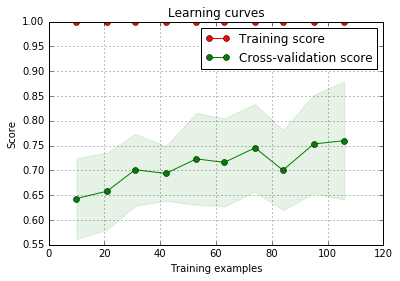

In [15]:
from sklearn.cross_validation import StratifiedKFold
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), scoring = None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

from sklearn.learning_curve import learning_curve

#Plotting learning curves for one of the model (country 2)
forest_for_plot = RandomForestClassifier(n_estimators = 200, )
cv = StratifiedKFold(ys[1], n_folds = 5)
plot_learning_curve(forest_for_plot,'Learning curves', trains_new[1], ys[1], cv = cv, train_sizes = np.linspace(.1, 1.0, 10))
plt.show()